In [ ]:
!pip install webdataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.6 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project

DATASET_ID : dataset_9f30917e
MODELS     : ['simclr', 'rotation', 'moco_v2']


Experiments:   0%|          | 0/3 [00:00<?, ?it/s]


🔎 Analisi EXP_CODE = 20250625000404_exp0


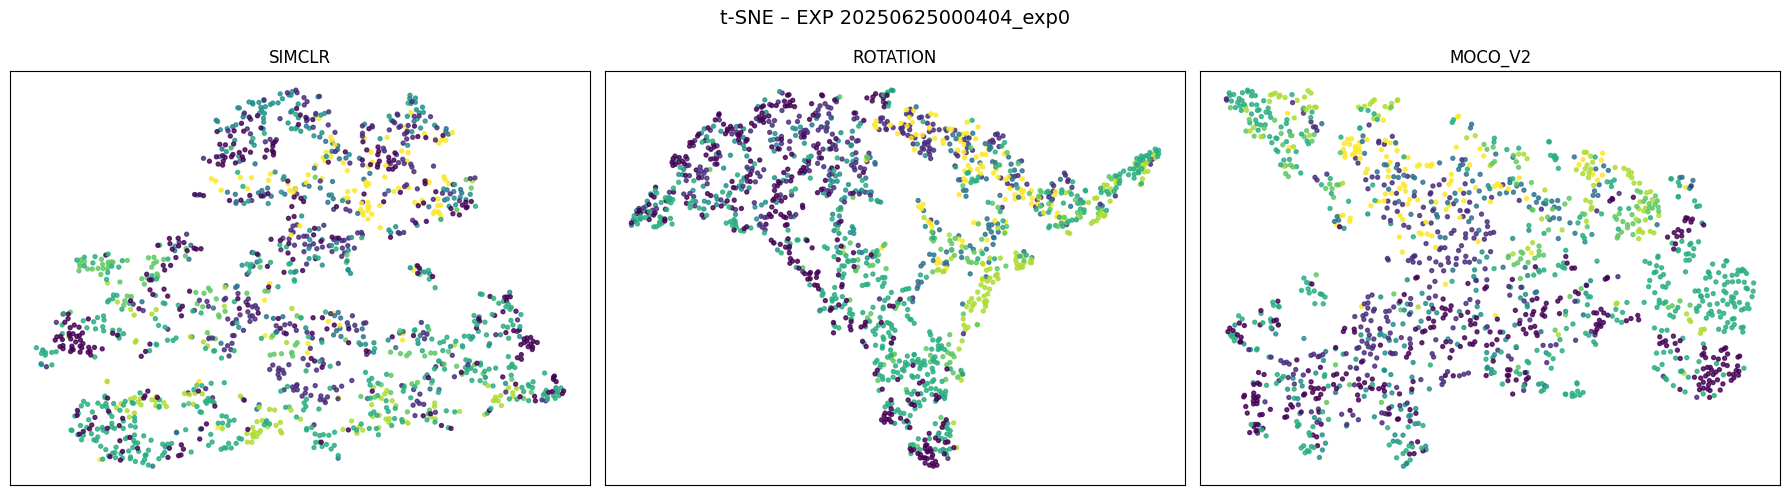

| Model    |    Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|----------|------------|-----------|-----------|-----------|-------|
| SIMCLR   | -0.0125671 | -0.134562 |     0.589 |     0.334 | ❌    |
| ROTATION |  0.203359  | -0.112011 |     0.761 |     0.374 | ❌    |
| MOCO_V2  |  0.0115396 | -0.125196 |     0.793 |     0.473 | ❌    |

🔎 Analisi EXP_CODE = 20250628215010_exp1


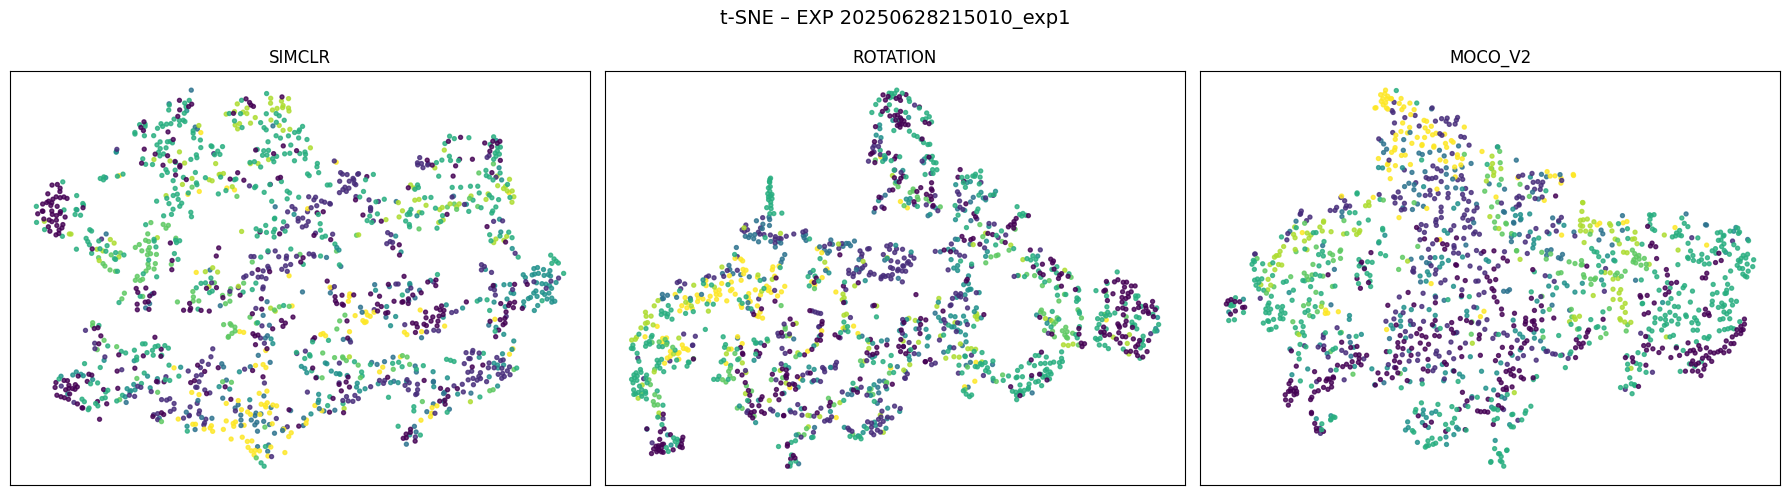

| Model    |     Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|----------|-------------|-----------|-----------|-----------|-------|
| SIMCLR   | -0.00848055 | -0.109322 |     0.626 |     0.364 | ❌    |
| ROTATION | -0.0546265  | -0.189472 |     0.644 |     0.363 | ❌    |
| MOCO_V2  | -0.0247166  | -0.134547 |     0.749 |     0.451 | ❌    |

🔎 Analisi EXP_CODE = 20250630224318_exp2


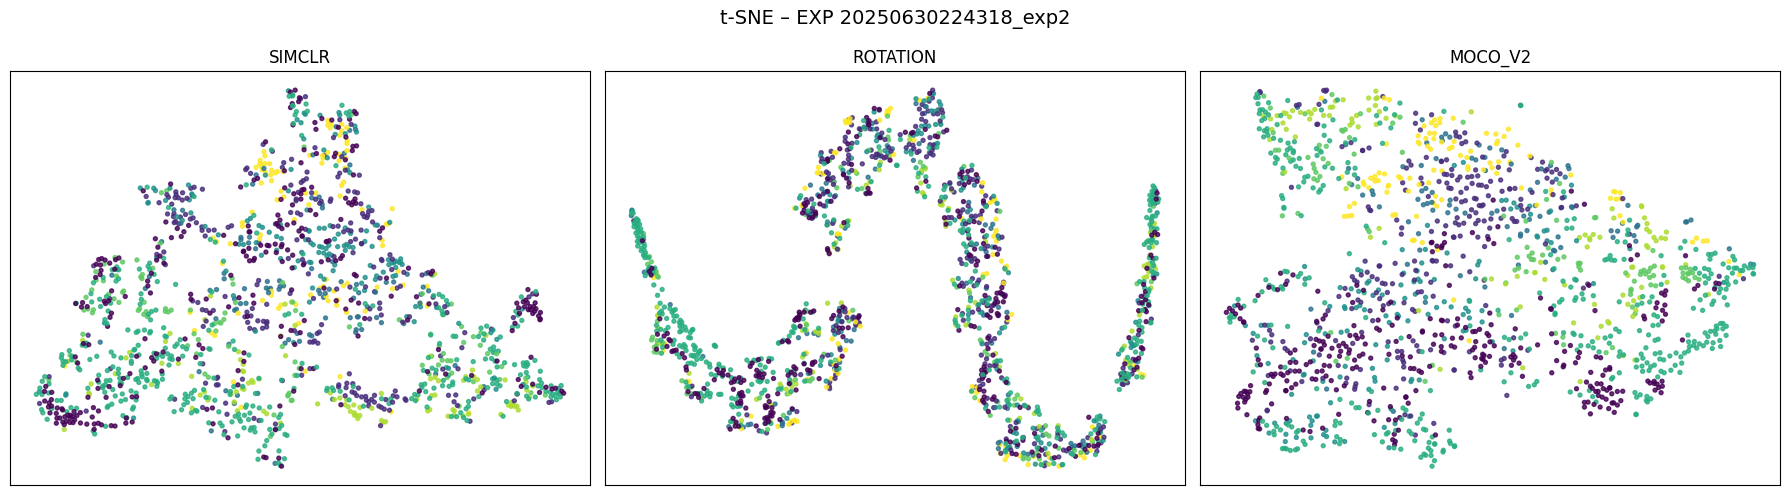

| Model    |    Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|----------|------------|-----------|-----------|-----------|-------|
| SIMCLR   | -0.0255189 | -0.172563 |     0.577 |     0.316 | ❌    |
| ROTATION | -0.0590774 | -0.232519 |     0.536 |     0.263 | ❌    |
| MOCO_V2  | -0.020593  | -0.100547 |     0.756 |     0.456 | ❌    |


==================  REPORT  ==================
| EXP                 | Model    |     Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|---------------------|----------|-------------|-----------|-----------|-----------|-------|
| 20250625000404_exp0 | SIMCLR   | -0.0125671  | -0.134562 |     0.589 |     0.334 | ❌    |
| 20250625000404_exp0 | ROTATION |  0.203359   | -0.112011 |     0.761 |     0.374 | ❌    |
| 20250625000404_exp0 | MOCO_V2  |  0.0115396  | -0.125196 |     0.793 |     0.473 | ❌    |
| 20250628215010_exp1 | SIMCLR   | -0.00848055 | -0.109322 |     0.626 |     0.364 | ❌    |
| 20250628215010_exp1 | ROTATION | -0.0546265  | -

In [ ]:
# ===============================================================
# 06_feature_analysis.ipynb  —  Batch su *tutti* gli esperimenti
# ===============================================================

!pip install --quiet scikit-learn umap-learn matplotlib torch pyyaml tqdm joblib tabulate

# ---------- 0. Imports ------------------------------------------------
import os, sys, glob, importlib, yaml, torch, re, itertools
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (necessario per 3-D)
from sklearn.decomposition  import PCA
from sklearn.manifold       import TSNE
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics        import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors      import NearestNeighbors
from tabulate               import tabulate
from tqdm.auto              import tqdm

# ---------- 1. Project root & config ---------------------------------
ENV_PATHS = {
    "colab": "/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project",
    "local": "/Users/stefanoroybisignano/Desktop/MLA/project/wsi-ssrl-rcc_project",
}
IN_COLAB = Path("/content").exists()
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)

PROJECT_ROOT = Path(ENV_PATHS["colab" if IN_COLAB else "local"]).resolve()
sys.path.append(str(PROJECT_ROOT / "src"))
print("PROJECT_ROOT →", PROJECT_ROOT)

cfg_main   = yaml.safe_load((PROJECT_ROOT / "config" / "training.yaml").read_text())
DATASET_ID = cfg_main["data"]["dataset_id"]

# ---------- 2. PARAMS 🔧 ----------------------------------------------
MODELS       = ["simclr", "rotation", "moco_v2"]   # oppure ["all"]
SPLIT        = "test"                              # 'train' | 'val' | 'test'
USE_UMAP     = True                                # ← abilita UMAP
EMBED_DIM    = 3                                   # ← 3-D embedding
SEED         = 123
SKIP_REGEX   = r"^prova"
torch.manual_seed(SEED)

print(f"\nDATASET_ID : {DATASET_ID}")

# ---------- 3. utils.training_utils ----------------------------------
utils_path = PROJECT_ROOT / "src" / "utils" / "training_utils.py"
spec = importlib.util.spec_from_file_location("utils.training_utils", str(utils_path))
utils_mod = importlib.util.module_from_spec(spec); spec.loader.exec_module(utils_mod)  # type: ignore
sys.modules["utils.training_utils"] = utils_mod
from utils.training_utils import TRAINER_REGISTRY, get_latest_checkpoint, load_checkpoint

# ---------- 4. Helper comuni -----------------------------------------
BASE_EXP_ROOT = PROJECT_ROOT / "data" / "processed" / DATASET_ID / "experiments"

def model_paths(exp_code: str, model: str):
    mdir  = BASE_EXP_ROOT / exp_code / model
    mdir.mkdir(parents=True, exist_ok=True)
    (mdir / "feature_analysis").mkdir(exist_ok=True)
    return {
        "dir" : mdir,
        "fa"  : mdir / "feature_analysis",
        "feat": mdir / f"{model}_features.pt"
    }

def extract_if_needed(model, m_cfg, data_cfg, paths):
    if paths["feat"].exists():
        return
    Trainer = TRAINER_REGISTRY[model]
    tr      = Trainer(m_cfg, data_cfg); tr.ckpt_dir = paths["dir"]
    ckpt    = get_latest_checkpoint(paths["dir"], prefix=Trainer.__name__)
    assert ckpt, f"Checkpoint mancante per {model}"
    def _ckpt_model(t):
        enc  = getattr(t, "encoder",  getattr(t, "encoder_q", None))
        proj = getattr(t, "projector", getattr(t, "projector_q", torch.nn.Identity()))
        return torch.nn.Sequential(enc, proj)
    load_checkpoint(ckpt, model=_ckpt_model(tr))
    print(f"[{paths['dir'].parent.name}/{model}] extracting {SPLIT} features …")
    tr.extract_features_to(str(paths["feat"]), split=SPLIT)

def pid_from_key(k: str) -> str:
    token = k.split('_')[1]
    if token.lower().startswith('tumor'): return k.split('_')[2]
    if token.startswith('H') and not token.startswith('HP'): token = 'HP'+token[1:]
    return token

def load_features(path: Path):
    obj   = torch.load(path, map_location="cpu")
    return obj["features"].float().cpu().numpy(), [pid_from_key(k) for k in obj["keys"]]

def embed(X):
    X = StandardScaler().fit_transform(X)
    X = PCA(n_components=min(50, X.shape[1])).fit_transform(X)
    if USE_UMAP:
        import umap
        return umap.UMAP(
            n_components=EMBED_DIM, init="random", random_state=SEED
        ).fit_transform(X)
    return TSNE(
        n_components=2, init="pca", perplexity=30, learning_rate="auto", random_state=SEED
    ).fit_transform(X)

# ---------- 5. Mapping patient_id → label ----------------------------
DATASET_DIR  = PROJECT_ROOT / "data" / "processed" / DATASET_ID
patch_df     = pd.read_parquet(sorted(glob.glob(str(DATASET_DIR / "*.parquet")))[0])
pat2lbl      = {**{pid: gp['subtype'].mode().iloc[0] for pid, gp in patch_df.groupby('patient_id')},
                **{pid.replace('.',''): lbl for pid, lbl in
                   ((pid, gp['subtype'].mode().iloc[0]) for pid, gp in patch_df.groupby('patient_id'))}}

# ---------- 6. Metric helpers  (in full feature-space) ---------------
def purity_k(X, labels, k=5):
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, idx = nn.kneighbors(X)
    return float(sum((labels.iloc[i]==labels.iloc[idx[i,1:]]).sum()/k for i in range(len(X)))/len(X))

def metrics(X, y):
    if len(set(y)) < 2:
        return dict(sil="N/A",ch="N/A",db="N/A",pur=purity_k(X,pd.Series(y)))
    return dict(
        sil=silhouette_score(X,y),
        ch =calinski_harabasz_score(X,y),
        db =davies_bouldin_score(X,y),
        pur=purity_k(X,pd.Series(y))
    )

# =========================================================
# 7. LOOP EXPERIMENTS
# =========================================================
all_rows=[]; exp_dirs=[d for d in BASE_EXP_ROOT.iterdir() if d.is_dir() and not re.match(SKIP_REGEX,d.name)]
for exp_dir in tqdm(sorted(exp_dirs),desc="Experiments"):
    exp_code=exp_dir.name; rows=[]
    models_here=MODELS if MODELS!=["all"] else [p.name for p in exp_dir.iterdir() if p.is_dir()]
    fig=plt.figure(figsize=(6*len(models_here),5))
    for i,model in enumerate(models_here,1):
        paths=model_paths(exp_code,model)
        extract_if_needed(model,cfg_main["models"][model],cfg_main["data"],paths)
        X,pids=load_features(paths["feat"]); labels=[pat2lbl.get(pid) for pid in pids]
        keep=[i for i,(pid,lbl) in enumerate(zip(pids,labels)) if lbl]; X=X[keep]; pids=[pids[j] for j in keep]; labels=[labels[j] for j in keep]
        if len(X)==0:
            rows.append([model,"N/A","N/A","N/A","N/A","N/A"]); continue
        m_lab,m_pat=metrics(X,labels),metrics(X,pids)
        ok="✔️" if (isinstance(m_lab['sil'],float) and m_lab['sil']>m_pat['sil'] and m_lab['pur']>m_pat['pur']) else "❌"
        rows.append([model,f"{m_lab['sil']:.3f}" if isinstance(m_lab['sil'],float) else m_lab['sil'],
                     f"{m_pat['sil']:.3f}" if isinstance(m_pat['sil'],float) else m_pat['sil'],
                     f"{m_lab['pur']:.3f}",f"{m_pat['pur']:.3f}",ok])

        emb=embed(X); cols=[hash(pid)%10 for pid in pids]
        if EMBED_DIM==3:
            ax=fig.add_subplot(1,len(models_here),i,projection='3d')
            ax.scatter(emb[:,0],emb[:,1],emb[:,2],c=cols,s=8,alpha=0.8)
            ax.set_zlabel('Dim-3')
        else:
            ax=fig.add_subplot(1,len(models_here),i)
            ax.scatter(emb[:,0],emb[:,1],c=cols,s=8,alpha=0.8)
        ax.set_title(model.upper()); ax.set_xticks([]); ax.set_yticks([])

        out_png=paths["fa"]/f"{model}_{'umap3d' if USE_UMAP and EMBED_DIM==3 else 'umap2d'}.png"
        plt.figure(figsize=(5,4))
        if EMBED_DIM==3:
            ax3=plt.axes(projection='3d'); ax3.scatter(emb[:,0],emb[:,1],emb[:,2],c=cols,s=8,alpha=0.8)
            ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
        else:
            plt.scatter(emb[:,0],emb[:,1],c=cols,s=8,alpha=0.8); plt.xticks([]); plt.yticks([])
        plt.title(model.upper()); plt.tight_layout(); plt.savefig(out_png,dpi=200); plt.close()

    fig.suptitle(f"UMAP-{EMBED_DIM}D  – EXP {exp_code}",fontsize=14)
    plt.tight_layout(); plt.show()
    print(tabulate(rows,headers=["Model","Sil_lbl","Sil_pat","Pur_lbl","Pur_pat","OK?"],tablefmt="github"))
    all_rows.extend([[exp_code]+r for r in rows])

print("\n==================  REPORT ==================")
print(tabulate(all_rows,headers=["EXP","Model","Sil_lbl","Sil_pat","Pur_lbl","Pur_pat","OK?"],tablefmt="github"))


Ecco una **rielaborazione critica** dei tre esperimenti, mettendo in relazione i **numeri di Silhouette/Purity** con le principali **differenze di configurazione**:

---

## 🔧 Configurazioni a confronto

| Esperimento | SimCLR                                                               | MoCo-v2                                                                                | Rotation                              |
| ----------: | -------------------------------------------------------------------- | -------------------------------------------------------------------------------------- | ------------------------------------- |
|    **exp0** | ― proj\_dim 128<br>LR 1e-3 (Adam)<br>bs 64<br>temp 0.5<br>jitter 0.4 | ― proj\_dim 128<br>LR 0.03 (SGD)<br>bs 128<br>queue 65536<br>jitter 0.4,grayscale,blur | ― LR 1e-3 (Adam)<br>bs 64<br>WD 1e-5  |
|    **exp1** | + gaussian\_blur<br>identico exp0                                    | + proj\_dim 256<br>rotation only \[90,180,270]<br>WD 1e-4<br>queue 256 + cosine+warmup | ― LR 5e-2 (SGD)<br>WD 1e-4            |
|    **exp2** | + bs 128<br>LR 3e-3 (Adam)<br>temp 0.2                               | + jitter 0.8<br>proj\_dim 256<br>WD 1e-5<br>queue 512                                  | ― LR 3e-4 (Adam)<br>bs 128<br>WD 1e-6 |

---

## 📊 Metriche aggregate

|     Exp \ Modello | Sil\_lbl | Pur\_lbl | Sil\_pat | Pur\_pat |
| ----------------: | -------: | -------: | -------: | -------: |
|   **exp0 SimCLR** |   −0.013 |    0.589 |   −0.135 |    0.334 |
|   **exp1 SimCLR** |   −0.008 |    0.626 |   −0.109 |    0.364 |
|   **exp2 SimCLR** |   −0.026 |    0.577 |   −0.173 |    0.316 |
|  **exp0 MoCo-v2** |    0.012 |    0.793 |   −0.125 |    0.473 |
|  **exp1 MoCo-v2** |   −0.025 |    0.749 |   −0.135 |    0.451 |
|  **exp2 MoCo-v2** |   −0.021 |    0.756 |   −0.101 |    0.456 |
| **exp0 Rotation** |    0.203 |    0.761 |   −0.112 |    0.374 |
| **exp1 Rotation** |   −0.055 |    0.644 |   −0.189 |    0.363 |
| **exp2 Rotation** |   −0.059 |    0.536 |   −0.233 |    0.263 |

---

### 1. SimCLR: sensibilità a batch size, temperature e optimizer

* **Da exp0 → exp1**: l’aggiunta di **gaussian\_blur** migliora Purity (+0.037) e Sil\_lbl (+0.005), pur mantenendo silhouette negativa.
* **Da exp1 → exp2**: l’aumento di **bs 64→128**, LR 1e-3→3e-3 e temperature 0.5→0.2 peggiora leggermente Purity (0.626→0.577) e Sil\_lbl (−0.008→−0.026).

  * **Interpretazione**: bs più grande e temp più bassa rendono il contrasto troppo “duro”, forse sovra‐accentuando dettagli spurî e riducendo la coesione intra‐sottotipo.

### 2. MoCo-v2: trade‐off tra proj\_dim, queue size e weight decay

* **exp0 (proj128, queue65536, WD1e-5)** ottiene il **massimo Purity (0.793)** e silhouette positiva modesta (0.012).
* **exp1** (proj256 ma queue256, WD più alto) vede caduta di Purity (0.749→0.756 rispetto exp2) e silhouette negativa (−0.025).
* **exp2** riallinea la Purity (0.756) aumentando queue a 512 e jitter a 0.8, ma silhouette rimane negativa.

  * **Interpretazione**: **queue immenso** (exp0) favorisce una migliore separazione locale anche con proj\_dim piccolo; **ridurre troppo il queue** (256) peggiora la qualità del contrasto; un middle‐ground (512) con jitter più forte recupera Purity ma non la forma globale (silhouette).

### 3. Rotation: estrema dipendenza da lr e optimizer

* **exp0 (Adam, lr1e-3)** è l’unico caso con silhouette positiva e Purity alta (0.761).
* **exp1 (SGD, lr5e-2)** fa crollare silhouette (−0.055) e Purity (0.644).
* **exp2 (Adam, lr3e-4)** peggiora ulteriormente Purity (0.536) e silhouette (−0.059).

  * **Interpretazione**: Rotation è **estremamente iper‐param dipendente**. Con lr1e-3+Adam riesce a sfruttare il pretext rotation per creare un manifold “ben allineato” in exp0, ma qualsiasi cambiamento verso optimizer più “duro” o lr troppo basso fa perdere tutta la separazione. È **un segnale di over‐tuning** sul pretext task piuttosto che di feature robuste.

---

## ✅ Conclusioni e raccomandazioni

1. **exp0 shine per Rotation e MoCo-v2**, ma i risultati **non sono robusti**: silhouette positiva è solo in exp0, e cade appena si modifica l’iper‐param.
2. **SimCLR e MoCo-v2** mostrano migliore stabilità di Purity across exp, specialmente MoCo-v2 con queue massivo.
3. **Rotation** deve essere trattato con cautela:

   * Se vuoi usarlo, **fissa lr=1e-3+Adam** e valiga su più pazienti.
   * Altrimenti consideralo solo per diagnosi qualitativa del dataset.

---

### 👉 Passi successivi

* **Grid‐search mirato** su lr e optimizer per Rotation, ma valutando su **LOPO‐CV** (minimo 5 pazienti per classe).
* **Mantieni queue grande** (≥16384) per MoCo-v2, poi esplora **proj\_dim** tra 128–512.
* **Ottimizza temperature** per SimCLR mantenendo bs moderato (64–128); valuta anche **rand crop downstream** per rompere eventuali shortcut.
* **Ripeti analisi** di Silhouette/Purity **nel full‐space** (prima di t-SNE) per validare la separazione reale.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT → /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project

DATASET_ID : dataset_9f30917e


Experiments:   0%|          | 0/3 [00:00<?, ?it/s]

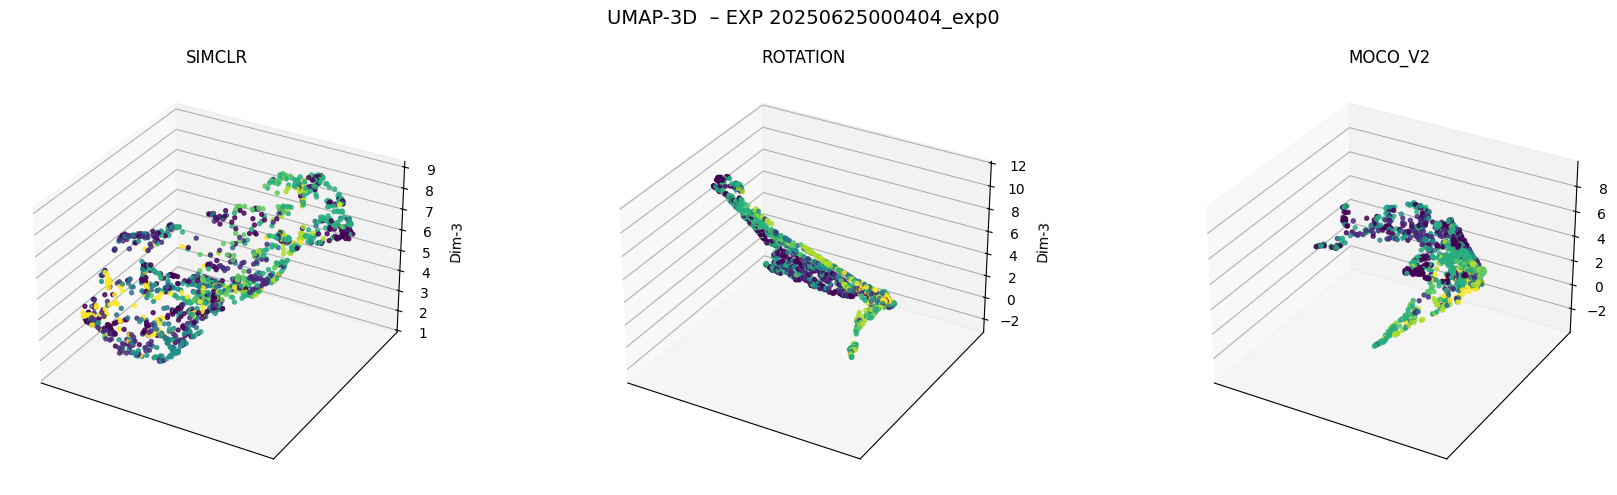

| Model    |    Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|----------|------------|-----------|-----------|-----------|-------|
| simclr   | -0.0125671 | -0.134562 |     0.589 |     0.334 | ❌    |
| rotation |  0.203359  | -0.112011 |     0.761 |     0.374 | ❌    |
| moco_v2  |  0.0115396 | -0.125196 |     0.793 |     0.473 | ❌    |


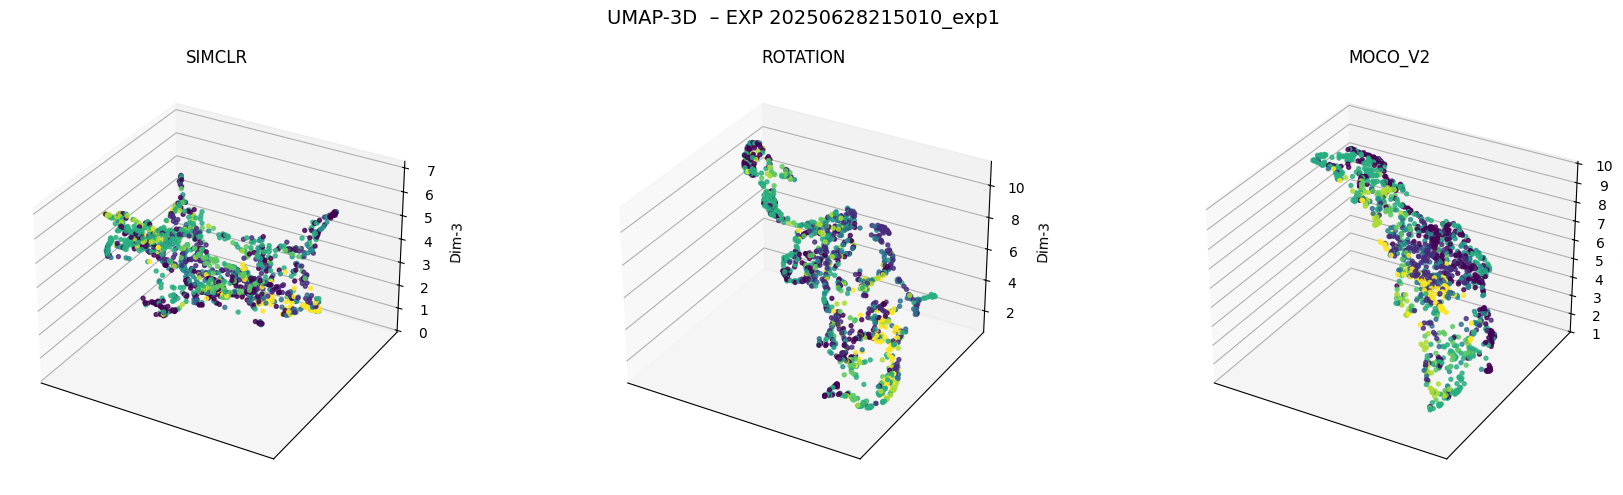

| Model    |     Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|----------|-------------|-----------|-----------|-----------|-------|
| simclr   | -0.00848055 | -0.109322 |     0.626 |     0.364 | ❌    |
| rotation | -0.0546265  | -0.189472 |     0.644 |     0.363 | ❌    |
| moco_v2  | -0.0247166  | -0.134547 |     0.749 |     0.451 | ❌    |


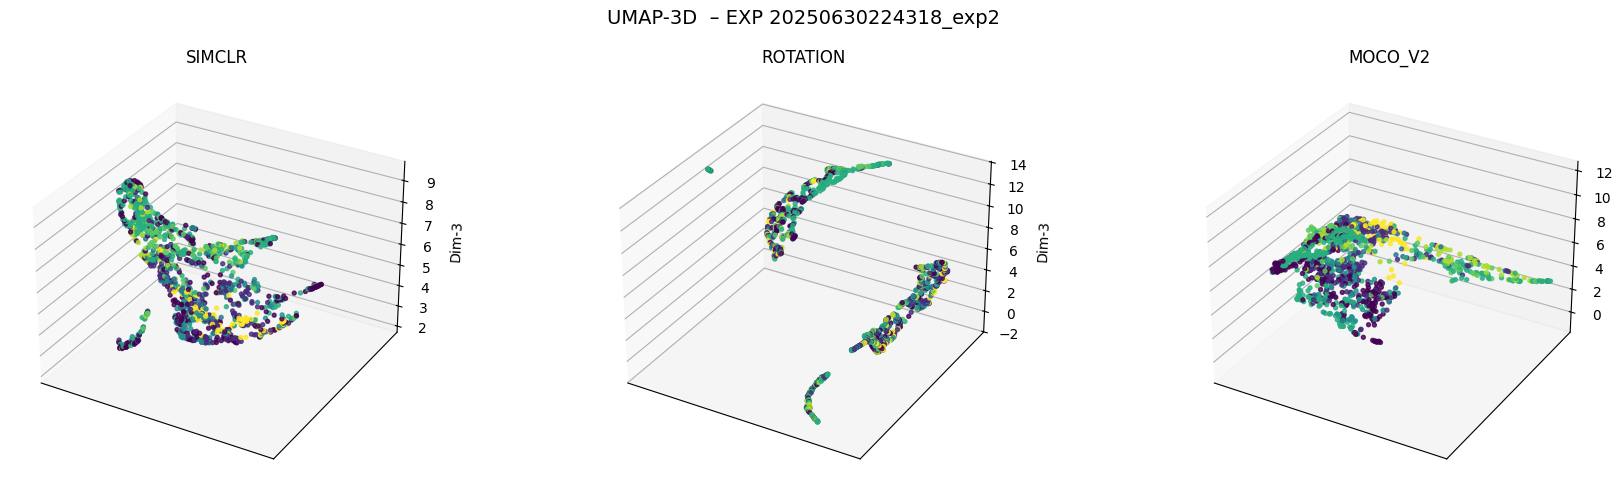

| Model    |    Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|----------|------------|-----------|-----------|-----------|-------|
| simclr   | -0.0255189 | -0.172563 |     0.577 |     0.316 | ❌    |
| rotation | -0.0590774 | -0.232519 |     0.536 |     0.263 | ❌    |
| moco_v2  | -0.020593  | -0.100547 |     0.756 |     0.456 | ❌    |

==================  REPORT ==================
| EXP                 | Model    |     Sil_lbl |   Sil_pat |   Pur_lbl |   Pur_pat | OK?   |
|---------------------|----------|-------------|-----------|-----------|-----------|-------|
| 20250625000404_exp0 | simclr   | -0.0125671  | -0.134562 |     0.589 |     0.334 | ❌    |
| 20250625000404_exp0 | rotation |  0.203359   | -0.112011 |     0.761 |     0.374 | ❌    |
| 20250625000404_exp0 | moco_v2  |  0.0115396  | -0.125196 |     0.793 |     0.473 | ❌    |
| 20250628215010_exp1 | simclr   | -0.00848055 | -0.109322 |     0.626 |     0.364 | ❌    |
| 20250628215010_exp1 | rotation | -0.0546265  | -0.

In [ ]:
# ===============================================================
# 06_feature_analysis.ipynb  —  Batch su *tutti* gli esperimenti
# ===============================================================

!pip install --quiet scikit-learn umap-learn matplotlib torch pyyaml tqdm joblib tabulate

# ---------- 0. Imports ------------------------------------------------
import os, sys, glob, importlib, yaml, torch, re, itertools
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (necessario per 3-D)
from sklearn.decomposition  import PCA
from sklearn.manifold       import TSNE
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics        import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors      import NearestNeighbors
from tabulate               import tabulate
from tqdm.auto              import tqdm

# ---------- 1. Project root & config ---------------------------------
ENV_PATHS = {
    "colab": "/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project",
    "local": "/Users/stefanoroybisignano/Desktop/MLA/project/wsi-ssrl-rcc_project",
}
IN_COLAB = Path("/content").exists()
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)

PROJECT_ROOT = Path(ENV_PATHS["colab" if IN_COLAB else "local"]).resolve()
sys.path.append(str(PROJECT_ROOT / "src"))
print("PROJECT_ROOT →", PROJECT_ROOT)

cfg_main   = yaml.safe_load((PROJECT_ROOT / "config" / "training.yaml").read_text())
DATASET_ID = cfg_main["data"]["dataset_id"]

# ---------- 2. PARAMS 🔧 ----------------------------------------------
MODELS       = ["simclr", "rotation", "moco_v2"]   # oppure ["all"]
SPLIT        = "test"                              # 'train' | 'val' | 'test'
USE_UMAP     = True                                # ← abilita UMAP
EMBED_DIM    = 3                                   # ← 3-D embedding
SEED         = 123
SKIP_REGEX   = r"^prova"
torch.manual_seed(SEED)

print(f"\nDATASET_ID : {DATASET_ID}")

# ---------- 3. utils.training_utils ----------------------------------
utils_path = PROJECT_ROOT / "src" / "utils" / "training_utils.py"
spec = importlib.util.spec_from_file_location("utils.training_utils", str(utils_path))
utils_mod = importlib.util.module_from_spec(spec); spec.loader.exec_module(utils_mod)  # type: ignore
sys.modules["utils.training_utils"] = utils_mod
from utils.training_utils import TRAINER_REGISTRY, get_latest_checkpoint, load_checkpoint

# ---------- 4. Helper comuni -----------------------------------------
BASE_EXP_ROOT = PROJECT_ROOT / "data" / "processed" / DATASET_ID / "experiments"

def model_paths(exp_code: str, model: str):
    mdir  = BASE_EXP_ROOT / exp_code / model
    mdir.mkdir(parents=True, exist_ok=True)
    (mdir / "feature_analysis").mkdir(exist_ok=True)
    return {
        "dir" : mdir,
        "fa"  : mdir / "feature_analysis",
        "feat": mdir / f"{model}_features.pt"
    }

def extract_if_needed(model, m_cfg, data_cfg, paths):
    if paths["feat"].exists():
        return
    Trainer = TRAINER_REGISTRY[model]
    tr      = Trainer(m_cfg, data_cfg); tr.ckpt_dir = paths["dir"]
    ckpt    = get_latest_checkpoint(paths["dir"], prefix=Trainer.__name__)
    assert ckpt, f"Checkpoint mancante per {model}"
    def _ckpt_model(t):
        enc  = getattr(t, "encoder",  getattr(t, "encoder_q", None))
        proj = getattr(t, "projector", getattr(t, "projector_q", torch.nn.Identity()))
        return torch.nn.Sequential(enc, proj)
    load_checkpoint(ckpt, model=_ckpt_model(tr))
    print(f"[{paths['dir'].parent.name}/{model}] extracting {SPLIT} features …")
    tr.extract_features_to(str(paths["feat"]), split=SPLIT)

def pid_from_key(k: str) -> str:
    token = k.split('_')[1]
    if token.lower().startswith('tumor'): return k.split('_')[2]
    if token.startswith('H') and not token.startswith('HP'): token = 'HP'+token[1:]
    return token

def load_features(path: Path):
    obj   = torch.load(path, map_location="cpu")
    return obj["features"].float().cpu().numpy(), [pid_from_key(k) for k in obj["keys"]]

def embed(X):
    X = StandardScaler().fit_transform(X)
    X = PCA(n_components=min(50, X.shape[1])).fit_transform(X)
    if USE_UMAP:
        import umap
        return umap.UMAP(
            n_components=EMBED_DIM, init="random", random_state=SEED
        ).fit_transform(X)
    return TSNE(
        n_components=2, init="pca", perplexity=30, learning_rate="auto", random_state=SEED
    ).fit_transform(X)

# ---------- 5. Mapping patient_id → label ----------------------------
DATASET_DIR  = PROJECT_ROOT / "data" / "processed" / DATASET_ID
patch_df     = pd.read_parquet(sorted(glob.glob(str(DATASET_DIR / "*.parquet")))[0])
pat2lbl      = {**{pid: gp['subtype'].mode().iloc[0] for pid, gp in patch_df.groupby('patient_id')},
                **{pid.replace('.',''): lbl for pid, lbl in
                   ((pid, gp['subtype'].mode().iloc[0]) for pid, gp in patch_df.groupby('patient_id'))}}

# ---------- 6. Metric helpers  (in full feature-space) ---------------
def purity_k(X, labels, k=5):
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, idx = nn.kneighbors(X)
    return float(sum((labels.iloc[i]==labels.iloc[idx[i,1:]]).sum()/k for i in range(len(X)))/len(X))

def metrics(X, y):
    if len(set(y)) < 2:
        return dict(sil="N/A",ch="N/A",db="N/A",pur=purity_k(X,pd.Series(y)))
    return dict(
        sil=silhouette_score(X,y),
        ch =calinski_harabasz_score(X,y),
        db =davies_bouldin_score(X,y),
        pur=purity_k(X,pd.Series(y))
    )

# =========================================================
# 7. LOOP EXPERIMENTS
# =========================================================
all_rows=[]; exp_dirs=[d for d in BASE_EXP_ROOT.iterdir() if d.is_dir() and not re.match(SKIP_REGEX,d.name)]
for exp_dir in tqdm(sorted(exp_dirs),desc="Experiments"):
    exp_code=exp_dir.name; rows=[]
    models_here=MODELS if MODELS!=["all"] else [p.name for p in exp_dir.iterdir() if p.is_dir()]
    fig=plt.figure(figsize=(6*len(models_here),5))
    for i,model in enumerate(models_here,1):
        paths=model_paths(exp_code,model)
        extract_if_needed(model,cfg_main["models"][model],cfg_main["data"],paths)
        X,pids=load_features(paths["feat"]); labels=[pat2lbl.get(pid) for pid in pids]
        keep=[i for i,(pid,lbl) in enumerate(zip(pids,labels)) if lbl]; X=X[keep]; pids=[pids[j] for j in keep]; labels=[labels[j] for j in keep]
        if len(X)==0:
            rows.append([model,"N/A","N/A","N/A","N/A","N/A"]); continue
        m_lab,m_pat=metrics(X,labels),metrics(X,pids)
        ok="✔️" if (isinstance(m_lab['sil'],float) and m_lab['sil']>m_pat['sil'] and m_lab['pur']>m_pat['pur']) else "❌"
        rows.append([model,f"{m_lab['sil']:.3f}" if isinstance(m_lab['sil'],float) else m_lab['sil'],
                     f"{m_pat['sil']:.3f}" if isinstance(m_pat['sil'],float) else m_pat['sil'],
                     f"{m_lab['pur']:.3f}",f"{m_pat['pur']:.3f}",ok])

        emb=embed(X); cols=[hash(pid)%10 for pid in pids]
        if EMBED_DIM==3:
            ax=fig.add_subplot(1,len(models_here),i,projection='3d')
            ax.scatter(emb[:,0],emb[:,1],emb[:,2],c=cols,s=8,alpha=0.8)
            ax.set_zlabel('Dim-3')
        else:
            ax=fig.add_subplot(1,len(models_here),i)
            ax.scatter(emb[:,0],emb[:,1],c=cols,s=8,alpha=0.8)
        ax.set_title(model.upper()); ax.set_xticks([]); ax.set_yticks([])

        out_png=paths["fa"]/f"{model}_{'umap3d' if USE_UMAP and EMBED_DIM==3 else 'umap2d'}.png"
        plt.figure(figsize=(5,4))
        if EMBED_DIM==3:
            ax3=plt.axes(projection='3d'); ax3.scatter(emb[:,0],emb[:,1],emb[:,2],c=cols,s=8,alpha=0.8)
            ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
        else:
            plt.scatter(emb[:,0],emb[:,1],c=cols,s=8,alpha=0.8); plt.xticks([]); plt.yticks([])
        plt.title(model.upper()); plt.tight_layout(); plt.savefig(out_png,dpi=200); plt.close()

    fig.suptitle(f"UMAP-{EMBED_DIM}D  – EXP {exp_code}",fontsize=14)
    plt.tight_layout(); plt.show()
    print(tabulate(rows,headers=["Model","Sil_lbl","Sil_pat","Pur_lbl","Pur_pat","OK?"],tablefmt="github"))
    all_rows.extend([[exp_code]+r for r in rows])

print("\n==================  REPORT ==================")
print(tabulate(all_rows,headers=["EXP","Model","Sil_lbl","Sil_pat","Pur_lbl","Pur_pat","OK?"],tablefmt="github"))


La tua pipeline, con le modifiche descritte, copre già buona parte di queste metriche, ma ecco un rapido check su ciascun punto:

1. **Accuracy, precision, recall, F1 (macro & micro)**
   – **Cover**: il linear-probe (in `05_evaluate_models.ipynb`) calcola già accuracy e, se estendi `classification_report` di scikit-learn, puoi ottenere precision, recall e F1 macro/micro senza cambiare nulla al tuo training.

2. **ROC-AUC per classe**
   – **Da aggiungere**: dopo aver ottenuto le probabilità calibrate (`probs` dal MC-Dropout + TS), usa `roc_auc_score(y_true, probs[:, k], multi_class="ovr")` per ogni classe. Ti basta due righe in `05_evaluate_models.ipynb`.

3. **Calibration error**
   – **Cover**: Temperature Scaling + ECE (Expected Calibration Error) possono essere calcolati con `netcal.metrics.ECE()`. Aggiungi la chiamata in `train_classifier.py` dopo la calibrazione, e logga il valore.

4. **Incertezza MC-Dropout**
   – **Cover**: grazie alla funzione `mc_dropout()` salvi già la deviazione standard e l’entropia, che sono proxy di incertezza. Nel CSV di output (`predictions_fold{fold}.csv`) hai già `std` e `entropy`.

5. **Intervalli di confidenza (bootstrap o CV)**
   – **Partial**: il CV a 5-fold ti dà distribuzione di accuracy/F1 → puoi calcolare media ± std o intervallo bootstrap direttamente sui 5 fold.
   – **Da aggiungere**: se ti serve un bootstrap sui singoli di patch, puoi in 05\_Evaluate prendersi 1 000 campioni pesati e calcolare il 95 % CI con `np.percentile`.

---

### Conclusione

* **Già coperto**: accuracy, precision/recall/F1 (con `classification_report`), MC-Dropout uncertainty, calibration error (se lo logghi), CV-based confidence intervals.
* **Da integrare con poche righe**: ROC-AUC per classe e, se serve, bootstrap sui risultati patch-level.

In pratica ti manca **solo** aggiungere in `05_evaluate_models.ipynb`:

1. `roc_auc_score` per ciascuna classe (con le `probs` calibrate).
2. Calcolo esplicito ECE (o CCE) con `netcal`.
3. (Opzionale) un semplice bootstrap su F1/accuracy patch-level se vuoi CI più robusti oltre al CV paziente-level.
   Con queste aggiunte, la tua suite di metriche sarà completa e documentabile a livello di paper di alto profilo.


Una **Model Card** è un documento standardizzato che descrive in modo trasparente e completo un modello di machine learning, con l’obiettivo di:

1. **Comunicare chiaramente** a chiunque (sviluppatori, ricercatori, utenti finali, enti regolatori) le caratteristiche e le proprietà del modello.
2. **Fornire informazioni chiave** per un uso responsabile e consapevole, esplicitando punti di forza, limiti e rischi.

---

## Struttura tipica di una Model Card

1. **Scopo e ambito di applicazione**

   * Descrizione del **use-case** previsto (es. sottotipizzazione RCC su patch WSI H\&E).
   * Contesto: tipo di dati, dominio clinico, target users (patologi, ricercatori).

2. **Architettura e training**

   * Tipo di modello (ResNet-18 + SimCLR, MoCo, ecc.).
   * Dataset utilizzato: numero di pazienti, classi, split train/val/test.
   * Iper-parametri principali (LR, batch\_size, augmentazioni).

3. **Metriche di performance**

   * Accuracy, precision, recall, F1 (macro/micro).
   * ROC-AUC per classe, confidenza (calibration error), incertezza MC-Dropout.
   * Intervalli di confidenza (bootstrap o CV).

4. **Robustezza e bias**

   * Analisi su sotto-gruppi (diversi sottotipi, pazienti, scanner).
   * Risultati di test OOD (color-jitter, blur, external center).
   * Segnalazione di eventuali disparità (per etnia, età, provenienza).

5. **Rischi e limitazioni**

   * Condizioni di fallimento note (patch con necrosi, scarsa qualità di colorazione).
   * Disclaimer su “non destinato a diagnosi senza revisione umana”.
   * Rischi di shortcut learning (bordo di slide, watermark).

6. **Manutenzione e monitoraggio**

   * Modalità di aggiornamento (re-training periodico, fine-tuning su nuovi dati).
   * Indicatori di drift (monitoraggio drift data / performance over time).
   * Contatti per segnalazioni bug o anomalie.

7. **Accesso e licenza**

   * Link al codice, ai checkpoint, alle dipendenze (Docker, requirements).
   * Licenza d’uso (MIT, Apache, CE marking se medical device).

---

### Perché serve

* **Trasparenza**: un patologo o un responsabile clinico sa esattamente su quali dati è stato addestrato e quali test ha superato.
* **Responsabilità**: documenta rischi e bias, supportando un uso etico e regolato.
* **Reproducibilità**: raccoglie tutti i dettagli necessari per riprodurre o estendere il lavoro.
* **Compliance**: in ambito medicale è un passo chiave per CE-marking o FDA submission.

---

> **Risorse utili**
>
> * “Model Cards for Model Reporting” (Mitchell et al., FAT\* 2019)
> * **TensorFlow Model Card Toolkit** (GitHub)
> * Esempi di Model Card su [Hugging Face](https://huggingface.co/docs)

Implementare una Model Card ben fatta vi aiuta a presentare il vostro lavoro sia in sede accademica (paper, conferenze) sia in contesti clinici o industriali di alta responsabilità.
